In [1]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
from scipy.stats import gaussian_kde
from numpy.random import uniform, normal

%matplotlib inline

### Tycho-2 Catalog

In [2]:
# Read in sample from Tycho-2 table

filename = ('../data/tycho-2/tyc2.dat')
readme = ('../data/tycho-2/ReadMe')
t = Table.read(filename, format='cds', guess=False, readme=readme)


# Now, generate a clean catalog
ids = np.intersect1d(np.where(t['q_pmRA'] >= 0.1), np.where(t['q_pmDE'] >= 0.1))
dtype = [('TYC','i8'),('TYC_s','S12'),('HIP','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'),('mu_ra_err','f8'), \
         ('mu_dec_err','f8'), ('V','f8'), ('B','f8')]
t_clean = np.zeros(len(ids), dtype=dtype)

t_clean['TYC'] = t['TYC1'][ids]*100000+t['TYC2'][ids]
t_clean['HIP'] = t['HIP'][ids]
t_clean['ra'] = t['RAmdeg'][ids]
t_clean['dec'] = t['DEmdeg'][ids]
t_clean['mu_ra'] = t['pmRA'][ids]
t_clean['mu_dec'] = t['pmDE'][ids]
t_clean['mu_ra_err'] = t['e_pmRA'][ids]
t_clean['mu_dec_err'] = t['e_pmDE'][ids]
t_clean['V'] = t['VTmag'][ids]
t_clean['B'] = t['BTmag'][ids]


for i in np.arange(len(t_clean)):
    t_clean['TYC_s'][i] = str(t['TYC1'][ids[i]]) + '-' + str(t['TYC2'][ids[i]]) + '-' + str(t['TYC3'][ids[i]])


In [13]:
readme = ('../data/tycho-2/ReadMe')

filename = ('../data/tycho-2/suppl_1.dat')
t_supp_1 = Table.read(filename, format='cds', guess=False, readme=readme)

filename = ('../data/tycho-2/suppl_2.dat')
t_supp_2 = Table.read(filename, format='cds', guess=False, readme=readme)

17588 1146


In [24]:
length_tyc_all = len(t) + len(t_supp_1) + len(t_supp_2)

dtype = [('TYC','S11'),('HIP','i8')]
tyc_hip = np.zeros(length_tyc_all, dtype=dtype)

tyc_hip['HIP'][0:len(t)] = t['HIP']
tyc_hip['HIP'][len(t):len(t) + len(t_supp_1)] = t_supp_1['HIP']
tyc_hip['HIP'][len(t) + len(t_supp_1):length_tyc_all] = t_supp_2['HIP']


for i in np.arange(length_tyc_all):
    if i < len(t):
        tyc_hip['TYC'][i] = str(t['TYC1'][i]) + '-' + str(t['TYC2'][i]) + '-' + str(t['TYC3'][i])
    elif i < len(t) + len(t_supp_1):
        tyc_hip['TYC'][i] = str(t_supp_1['TYC1'][i-len(t)]) + '-' + str(t_supp_1['TYC2'][i-len(t)]) + '-' + str(t_supp_1['TYC3'][i-len(t)])
    else:
        tyc_hip['TYC'][i] = str(t_supp_2['TYC1'][i-len(t)-len(t_supp_1)]) + '-' + str(t_supp_2['TYC2'][i-len(t)-len(t_supp_1)]) + '-' + str(t_supp_2['TYC3'][i-len(t)-len(t_supp_1)])
        
        

In [25]:
print len(tyc_hip['HIP'][len(t):len(t) + len(t_supp_1)])
print len(tyc_hip)
print len(t), len(t_supp_1), len(t_supp_2)

17588
2558647
2539913 17588 1146


In [32]:
print len(tyc_hip[tyc_hip['HIP'] != 0])

124246


In [35]:
tyc_hip_good = tyc_hip[tyc_hip['HIP'] != 0]
print len(tyc_hip_good)
np.savetxt('../tyc_hip.dat', tyc_hip_good, fmt='%s %i')

124246


In [11]:
print len(t)
print np.where(tyc_hip_good['HIP'] == 9607)[0]

2539913
[]


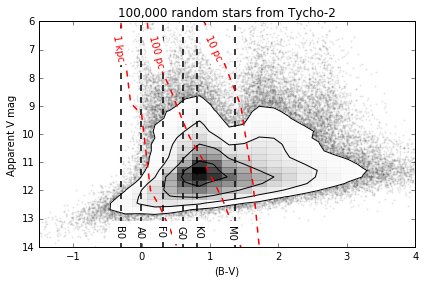

In [60]:
def get_V_app(V_abs, dist):
    return 5.0 * (np.log10(dist) - 1.0) + V_abs

abs_mags = [-5.8, -4.1, -1.1, -0.7, 2.0, 2.6, 3.4, \
            4.4, 5.1, 5.9, 7.3, 9.0, 11.8, 16.0]

BV_colors = [-0.35, -0.31, -0.16, 0.0, 0.13, 0.27, \
             0.42, 0.58, 0.70, 0.89, 1.18, 1.45, \
             1.63, 1.80]



BT = t["BTmag"]
VT = t["VTmag"]
# We can adjust to Johnson magnitudes using conversion from http://www.britastro.org/asteroids/Tycho%20Photometry.htm
V_mag = t["VTmag"] - 0.016 - 0.0741 * (t["BTmag"] - t["VTmag"])
B_mag = t["BTmag"] + 0.064 + 0.2983 * (t["BTmag"] - t["VTmag"])
BV_color = B_mag - V_mag
# From http://stupendous.rit.edu/tass/catalogs/tycho.html (Mamajek, Meyer, & Liebert 2002)
#V_mag = VT + 9.7e-4 - 0.1334*(BT-VT) + 5.486e-2*(BT-VT)**2 - 1.998e-2*(BT-VT)**3
#BV_color = BT-VT - 7.813e-3*(BT-VT) - 1.489e-1*(BT-VT)**2 + 3.384e-2*(BT-VT)**3
#BV_color[np.where(BT-VT < 0.5)] = BT-VT - 0.006 - 1.069e-1*(BT-VT) + 1.459e-1*(BT-VT)**2

#plt.scatter(BV_color, V_mag, marker='.', color='k', alpha=0.05)
corner.hist2d(BV_color, V_mag, bins=50)

plt.xlabel("(B-V)")
plt.ylabel("Apparent V mag")
plt.title("100,000 random stars from Tycho-2")

plt.xlim(-1.5, 4.0)
plt.ylim(14, 6)

# Add lines linking colors to stellar type
# Values from http://www.stsci.edu/~inr/intrins.html (Ducati et al. 2001)
plt.axvline(-0.3, color='k', linestyle='dashed', linewidth=1.5) # B0 star
plt.text(-0.4,13.5,'B0',rotation=-90, backgroundcolor='w')
plt.axvline(-0.01, color='k', linestyle='dashed', linewidth=1.5) # A0 star
plt.text(-0.1,13.5,'A0',rotation=-90, backgroundcolor='w')
plt.axvline(0.32, color='k', linestyle='dashed', linewidth=1.5) # F0 star
plt.text(0.2,13.5,'F0',rotation=-90, backgroundcolor='w')
plt.axvline(0.60, color='k', linestyle='dashed', linewidth=1.5) # G0 star
plt.text(0.5,13.5,'G0',rotation=-90, backgroundcolor='w')
plt.axvline(0.81, color='k', linestyle='dashed', linewidth=1.5) # K0 star
plt.text(0.75,13.5,'K0',rotation=-90, backgroundcolor='w')
plt.axvline(1.37, color='k', linestyle='dashed', linewidth=1.5) # M0 star
plt.text(1.24,13.5,'M0',rotation=-90, backgroundcolor='w')

plt.plot(BV_colors, get_V_app(abs_mags, 10.0), color='r', linestyle='dashed', linewidth=1.5)
plt.text(-0.45, 6.7, '1 kpc', rotation=-80, color='r', backgroundcolor='w')
plt.plot(BV_colors, get_V_app(abs_mags, 100.0), color='r', linestyle='dashed', linewidth=1.5)
plt.text(0.08, 6.7, '100 pc', rotation=-75, color='r', backgroundcolor='w')
plt.plot(BV_colors, get_V_app(abs_mags, 1000.0), color='r', linestyle='dashed', linewidth=1.5)
plt.text(0.9, 6.7, '10 pc', rotation=-65, color='r', backgroundcolor='w')

plt.tight_layout()
plt.savefig('../figures/tycho2_colors.pdf')
#plt.show()

### Tycho-2 Double Star Catalog

In [2]:
# Read in Tycho-2 Double Star Catalog table

filename = ('../data/TDSC/catalog.dat')
readme = ('../data/TDSC/ReadMe')
t_TDSC = Table.read(filename, format='ascii.fixed_width_no_header')

In [56]:
# Binary id
ID = t_TDSC['col1']

# Photometry
B_tyc = t_TDSC['col17']
V_tyc = t_TDSC['col19']

# Position
ra = t_TDSC['col5']
ra_err = t_TDSC['col7']
dec = t_TDSC['col6']
dec_err = t_TDSC['col8']

# Proper motion
mu_ra = t_TDSC['col12']
mu_ra_err = t_TDSC['col14']
mu_dec = t_TDSC['col13']
mu_dec_err = t_TDSC['col15']

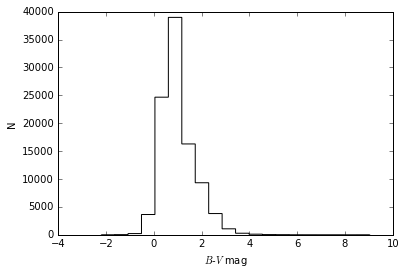

In [16]:
V_mag = V_tyc - 0.016 - 0.0741 * (B_tyc - V_tyc)
B_mag = B_tyc + 0.064 + 0.2983 * (B_tyc - V_tyc)


plt.hist(B_mag - V_mag, histtype='step', color='k', bins=20)
plt.xlabel(r'$B$-$V$ mag')
plt.ylabel('N')

plt.show()

In [80]:
def sep_degree(ra1, dec1, ra2, dec2):
    return np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

theta = np.array([])

for i in np.arange(len(t_TDSC)):
    if t_TDSC['col2'][i] == "A":
        ra1 = ra[i]
        dec1 = dec[i]
        continue
    
    ra2 = ra[i]
    dec2 = dec[i]
    
    theta = np.append(theta, sep_degree(ra1, dec1, ra2, dec2))
    
# theta is in degrees. Let's change to arcseconds
theta = theta * 3600.0

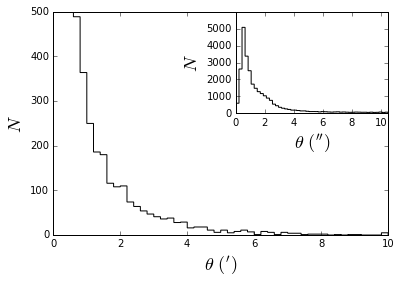

In [104]:
fig = plt.figure()

plt.hist(theta/60.0, histtype='step', range=[0.0, 10.0], color='k', bins=50)
plt.ylim(0.0, 500)
plt.xlim(0.0, 10.0)
plt.xlabel(r'$\theta\ (^{\prime})$', fontsize=18)
plt.ylabel(r'$N$', fontsize=18)

ax1 = fig.add_subplot(222)
ax1.hist(theta, histtype='step', range=[0.0,10.5], color='k', bins=50)
ax1.set_xlim(0.0, 10.5)
ax1.set_xlabel(r'$\theta\ (^{\prime\prime})$', fontsize=18)
ax1.set_ylabel(r'$N$', fontsize=18)
ax1.set_yticks([0, 1000, 2000, 3000, 4000, 5000])

plt.tight_layout()
plt.savefig('../figures/TDSC_separation.pdf')
#plt.show()

## Now, back to the Tycho-2 Catalog

In [3]:
print t.colnames

['TYC1', 'TYC2', 'TYC3', 'pflag', 'RAmdeg', 'DEmdeg', 'pmRA', 'pmDE', 'e_RAmdeg', 'e_DEmdeg', 'e_pmRA', 'e_pmDE', 'EpRAm', 'EpDEm', 'Num', 'q_RAmdeg', 'q_DEmdeg', 'q_pmRA', 'q_pmDE', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag', 'prox', 'TYC', 'HIP', 'CCDM', 'RAdeg', 'DEdeg', 'EpRA-1990', 'EpDE-1990', 'e_RAdeg', 'e_DEdeg', 'posflg', 'corr']


### Let's check quality of proper motion data

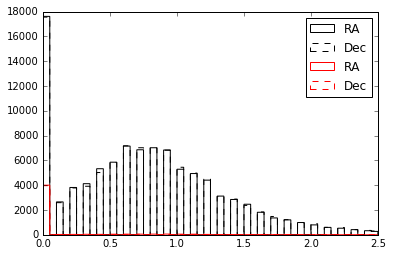

In [40]:
xmin, xmax = 0.0, 2.5

plt.hist(t['q_pmRA'], bins=50, color='k', histtype='step', linestyle='-', label='RA', range=[xmin,xmax])
plt.hist(t['q_pmDE'], bins=50, color='k', histtype='step', linestyle='--', label='Dec', range=[xmin,xmax])

plt.hist(t['q_pmRA'][np.where(t['pmRA']==0.0)], bins=50, color='r', histtype='step', linestyle='-', label='RA', range=[xmin,xmax])
plt.hist(t['q_pmDE'][np.where(t['pmDE']==0.0)], bins=50, color='r', histtype='step', linestyle='--', label='Dec', range=[xmin,xmax])

plt.legend()
plt.show()

### So, we will select only those pairs with proper motion qualities greater than 0.1 for both RA and Dec

We are left with 81227 systems
Just to check:


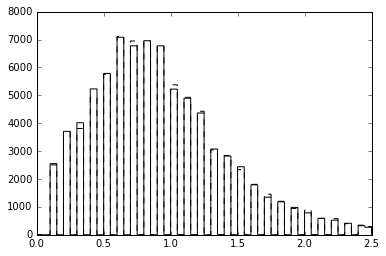

In [5]:
xmin, xmax = 0.0, 2.5

t_tmp = t[np.where(t['q_pmRA'] >= 0.1)]
t_clean = t_tmp[np.where(t_tmp['q_pmDE'] >= 0.1)]

print "We are left with", len(t_clean), "systems"

print "Just to check:"

plt.hist(t_clean['q_pmRA'], bins=50, color='k', histtype='step', linestyle='-', label='RA', range=[xmin,xmax])
plt.hist(t_clean['q_pmDE'], bins=50, color='k', histtype='step', linestyle='--', label='Dec', range=[xmin,xmax])

plt.show()

### Let's also look at the typical proper motion uncertainties

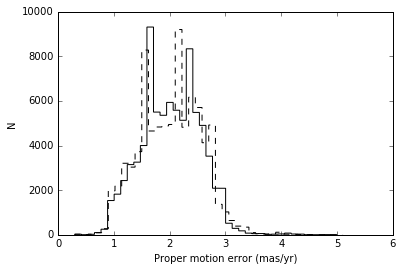

In [60]:
plt.hist(t_clean['e_pmRA'], histtype='step', color='k', linestyle='-', bins=40)
plt.hist(t_clean['e_pmDE'], histtype='step', color='k', linestyle='--', bins=40)

plt.xlabel('Proper motion error (mas/yr)')
plt.ylabel('N')

plt.show()

### Now, let's look at the proper motions

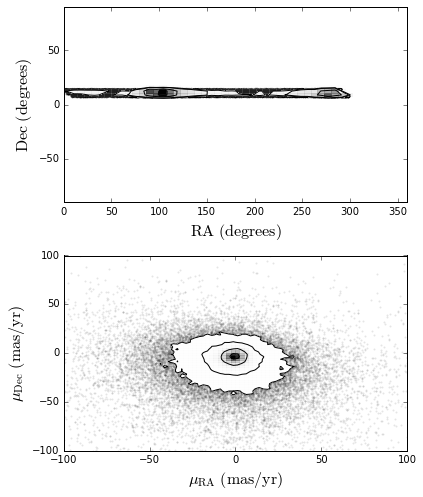

In [26]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':50}
corner.hist2d(t_clean['ra'], t_clean['dec'], range=[(0,360),(-90,90)], ax=ax[0], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA\ (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec\ (degrees)}$', size=16)

contourf_kwargs = {'bins':80}
corner.hist2d(t_clean['mu_ra'], t_clean['mu_dec'], range=[(-100,100),(-100,100)], ax=ax[1], **contourf_kwargs)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)

plt.tight_layout()
plt.savefig('../figures/tycho-2_pos_mu.pdf')
#plt.show()

### A sample system to check the method

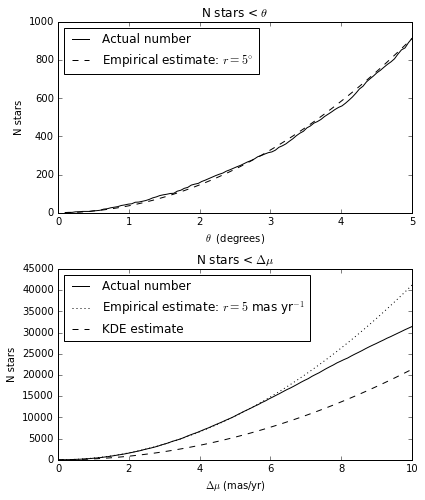

In [96]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

i=3344


# Position panel
ra_in = t_clean['RAmdeg'][i]
dec_in = t_clean['DEmdeg'][i] 
#print ra_in, dec_in

radius = np.linspace(0.1, 5.0, 100)
nstars = np.zeros(100)
for j in np.arange(100):
    r = radius[j]
    nstars[j] = nstars_nearby(ra_in, dec_in, radius=r, catalog=t_clean)-1
ax[0].plot(radius, nstars, color='k', label='Actual number')

# Compare to density estimate derived from a 5 degree radius
r = 5.0
n_stars_near = nstars_nearby(ra_in, dec_in, radius=r, catalog=t_clean)-1
n_density = n_stars_near / (4.0*np.pi*r**2)
y = (4.0*np.pi)*n_density*radius**2
ax[0].plot(radius,y, color='k', linestyle='--', label=r'Empirical estimate: $r=5^{\circ}$')

ax[0].set_title(r'N stars < $\theta$')
ax[0].set_xlabel(r'$\theta\ $ (degrees)')
ax[0].set_ylabel('N stars')
ax[0].legend(loc=2)




# Proper motion panel
mu_ra_in = t_clean['pmRA'][i]
mu_dec_in = t_clean['pmDE'][i] 

pm_density = get_P_mu(mu_ra_in, mu_dec_in, catalog=t_clean, method='kde')
delta_mu = np.linspace(0.0, 10.0, 100)
P_mu = 4.0*np.pi*delta_mu**2*pm_density

N_stars = np.zeros(100)
for i in np.arange(100):
    N_stars[i] = nstars_nearby_mu(mu_ra_in, mu_dec_in, delta_mu[i], catalog=t_clean)

ax[1].plot(delta_mu, N_stars, color='k', label='Actual number')



# Compare to density estimate derived from a 5 mas/yr radius
r = 5.0
n_stars_near = nstars_nearby_mu(mu_ra_in, mu_dec_in, radius=r, catalog=t_clean)-1
n_density = n_stars_near / (4.0*np.pi*r**2)
y = (4.0*np.pi)*n_density*delta_mu**2
ax[1].plot(delta_mu,y, color='k', linestyle='dotted', label=r'Empirical estimate: $r=5$ mas yr$^{-1}$')




norm_factor = mu_kde.factor*len(t_clean['RAmdeg'])
ax[1].plot(delta_mu, P_mu*norm_factor, color='k', linestyle='--', label='KDE estimate')

ax[1].set_xlim(0.0,10.0)

ax[1].set_title(r'N stars < $\Delta \mu$')
ax[1].set_xlabel(r'$\Delta \mu$ (mas/yr)')
ax[1].set_ylabel('N stars')

ax[1].legend(loc=2)


plt.tight_layout()
plt.savefig('../figures/tycho-2_local_density.pdf')
#plt.show()

### Generate set of binaries

In [14]:
P_binary.generate_binary_set(num_sys=1000000)

### Search through Tycho-2 Catalog

In [ ]:
n_mu_sample = 1000

length = len(t_clean)
#length = 40
print "We are testing", length, "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('TYC_1','i8'),('TYC_2','i8'),('P_random','f8'),('P_binary','f8'),('P_posterior','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length-1):
    
    if i%1000 == 0: print i
    
    star1 = t_clean['ra'][i], t_clean['dec'][i], t_clean['mu_ra'][i], t_clean['mu_dec'][i], \
            t_clean['mu_ra_err'][i], t_clean['mu_dec_err'][i]

    
    # Random Alignment densities
    pos_density = P_random.get_sigma_pos(star1[0], star1[1], catalog=t_clean, method='kde')
    pm_density = P_random.get_sigma_mu(star1[2], star1[3], catalog=t_clean, method='kde')

    
    prob = np.zeros(len(t_clean)-i-1)
    for j in np.arange(len(t_clean)-i-1)+i+1:

        # Prevent repeat entries from self-matching
        if t_clean['TYC'][i] == t_clean['TYC'][j]:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t_clean['ra'][j], t_clean['dec'][j], t_clean['mu_ra'][j], t_clean['mu_dec'][j], \
                t_clean['mu_ra_err'][j], t_clean['mu_dec_err'][j]

        # Only select stars within 1 degree
        theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1])
        if theta > 1.0: 
            prob[j-1-i] = 1000.0
            continue

        
        delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
        delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
                
        
        prob[j-i-1], P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t_clean)
        
    # Get best matching pair
    j = np.argmin(prob)+i+1
    star2 = t_clean['ra'][j], t_clean['dec'][j], t_clean['mu_ra'][j], t_clean['mu_dec'][j], \
            t_clean['mu_ra_err'][j], t_clean['mu_dec_err'][j]    
    theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
    delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)

    # Only include binary probability if star is within 1 degree
    if theta > 3600.0:
        prob_binary = 0.0
    else:
        delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=n_mu_sample)
        delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=n_mu_sample)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
        prob_binary = 1.0/n_mu_sample * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['TYC_1'][i] = t_clean['TYC'][i]
    prob_out['TYC_2'][i] = t_clean['TYC'][j]
    prob_out['P_random'][i] = prob[j-i-1]
    prob_out['P_binary'][i] = prob_binary
    prob_out['P_posterior'][i] = prob_binary / (prob[j-i-1] + prob_binary + 1.0e-99)
    
print "... finished"

In [120]:
length = len(t_clean)
#length = 2

print "We are testing", len(t_clean), "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('ID_1','i4'),('ID_2','i4'),('P_random','f8'),('P_binary','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length):
    
    if i%1000 == 0: print i
    
    star1 = t_clean['RAmdeg'][i], t_clean['DEmdeg'][i], t_clean['pmRA'][i], t_clean['pmDE'][i], t_clean['e_pmRA'][i], t_clean['e_pmDE'][i]

    # Random Alignment
    pos_density = get_local_density(star1[0], star1[1], catalog=t_clean)
    pm_density = get_P_mu(star1[2], star1[3], catalog=t_clean, method='empirical')

    # To Do: Select only potential companion stars within 1 degree as possible pairs

    # Set IDs
    ID_1 = t_clean['TYC1'][i]*100000+t_clean['TYC2'][i]
    
    prob = np.zeros(len(t_clean)-i-1)
    for j in np.arange(len(t_clean)-i-1)+i+1:

        ID_2 = t_clean['TYC1'][j]*100000+t_clean['TYC2'][j]
        if ID_1 == ID_2:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t_clean['RAmdeg'][j], t_clean['DEmdeg'][j], t_clean['pmRA'][j], t_clean['pmDE'][j], t_clean['e_pmRA'][j], t_clean['e_pmDE'][j]
        
        P_random = get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t_clean)

        prob[j-i-1] = P_random
        
#     # Binary probability for best matching pair
#     j = np.argmin(prob)+i+1
#     star2 = t_clean['RAmdeg'][j], t_clean['DEmdeg'][j], t_clean['pmRA'][j], t_clean['pmDE'][j], t_clean['e_pmRA'][j], t_clean['e_pmDE'][j]
#     theta = get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
#     delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
#     delta_mu_err = np.sqrt(star1[4]**2 + star1[5]**2 + star2[4]**2 + star2[5]**2)
#     if theta > 3600.0:
#         P_binary = 0.0
#     else:
#         delta_mu_sample = normal(loc=delta_mu, scale=delta_mu_err, size=100)
#         P_binary = 1.0/100 * np.sum(get_P_binary(theta, delta_mu_sample, sim_binaries=b))

    
    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['ID_1'][i] = ID_1
    prob_out['ID_2'][i] = ID_2
    prob_out['P_random'][i] = prob[j-i-1]
#     prob_out['P_binary'][i] = P_binary
    # print i, np.argmin(prob)+i+1, prob[np.argmin(prob)]
    
print "... finished"

We are testing 81227 stars...
0


KeyboardInterrupt: 

In [124]:
print len(prob_out["ID_1"][np.where(prob_out["ID_1"]>0.0)])

332
